In [1]:
# main packages and libraries
import laspy
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import open3d as o3d
import pandas as pd
from sklearn.neighbors import KDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Retrieve number of points, area, and average point density

In [2]:
# Define absolute paths
sfm_path = r"D:\JPC_July2025\Data\SfM_Clipped.las"
tls_path = r"D:\JPC_July2025\Data\TLS_Clipped.las"

def compute_point_density(las_file_path):
    las = laspy.read(las_file_path)
    x = las.x
    y = las.y
    n_points = len(x)

    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)

    area_m2 = (x_max - x_min) * (y_max - y_min)
    density = n_points / area_m2 if area_m2 > 0 else 0

    return density, n_points, area_m2

# Compute densities
sfm_density, sfm_npoints, sfm_area = compute_point_density(sfm_path)
tls_density, tls_npoints, tls_area = compute_point_density(tls_path)

# Display results
print(f"UAS-SfM Point Cloud:")
print(f" - Number of Points: {sfm_npoints}")
print(f" - Area (m²): {sfm_area:.2f}")
print(f" - Average Point Density (pts/m²): {sfm_density:.2f}\n")

print(f"TLS Point Cloud:")
print(f" - Number of Points: {tls_npoints}")
print(f" - Area (m²): {tls_area:.2f}")
print(f" - Average Point Density (pts/m²): {tls_density:.2f}")


UAS-SfM Point Cloud:
 - Number of Points: 4575513
 - Area (m²): 14069.76
 - Average Point Density (pts/m²): 325.20

TLS Point Cloud:
 - Number of Points: 35409031
 - Area (m²): 14061.93
 - Average Point Density (pts/m²): 2518.08


## Raster Differencing Calculations (Clipped Point Clouds)

In [3]:
# File names
dem1_path = "SfM_DEM_50cm.tif"  # Comparative DEM (SfM)
dem2_path = "TLS_DEM_50cm.tif"  # Reference DEM (TLS)

# Open DEMs
with rasterio.open(dem1_path) as dem1_src, rasterio.open(dem2_path) as dem2_src:
    dem1 = dem1_src.read(1)
    dem2 = dem2_src.read(1)

    # Ensure matching dimensions
    if dem1.shape != dem2.shape:
        raise ValueError("DEM dimensions do not match.")

    # Mask no data values
    mask = (dem1 == dem1_src.nodata) | (dem2 == dem2_src.nodata)
    diff = np.where(~mask, dem1 - dem2, np.nan)

# Flatten and remove NaNs
diff_valid = diff[~np.isnan(diff)]

# Metrics
rmse = np.sqrt(np.mean(diff_valid**2))
std_dev = np.std(diff_valid)
mean_diff = np.mean(diff_valid)
avg_error = np.mean(np.abs(diff_valid))
max_diff = np.max(diff_valid)
min_diff = np.min(diff_valid)
median_diff = np.median(diff_valid)

# Output metrics
print(f"RMSE: {rmse:.4f} m")
print(f"Standard Deviation: {std_dev:.4f} m")
print(f"Mean: {mean_diff:.4f} m")
print(f"Average Error (MAE): {avg_error:.4f} m")
print(f"Max: {max_diff:.4f} m")
print(f"Min: {min_diff:.4f} m")
print(f"Median: {median_diff:.4f} m")


RMSE: 0.2410 m
Standard Deviation: 0.2209 m
Mean: -0.0963 m
Average Error (MAE): 0.1064 m
Max: 0.6370 m
Min: -33.4840 m
Median: -0.0627 m


## Cloud-to-Cloud Assessments (Clipped Point Clouds)

In [4]:
def load_las_as_o3d(filepath):
    las = laspy.read(filepath)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

# Load point clouds
pcd_sfm = load_las_as_o3d("SfM_Clipped.las")
pcd_tls = load_las_as_o3d("TLS_Clipped.las")

# Convert to numpy arrays
sfm_pts = np.asarray(pcd_sfm.points)
tls_pts = np.asarray(pcd_tls.points)

# Ensure non-empty
if sfm_pts.size == 0 or tls_pts.size == 0:
    raise ValueError("One or both point clouds are empty.")

# KDTree-based C2C distance
tree = KDTree(tls_pts)
dists, _ = tree.query(sfm_pts, k=1)
dists = dists.flatten()

# Stats
rmse = np.sqrt(np.mean(dists**2))
std_dev = np.std(dists)
mean = np.mean(dists)
mae = np.mean(np.abs(dists))
max_val = np.max(dists)
min_val = np.min(dists)
median = np.median(dists)

# Colorize SfM points by distance
norm_dists = (dists - min_val) / (max_val - min_val)
colors = plt.get_cmap("viridis")(norm_dists)[:, :3]
pcd_sfm.colors = o3d.utility.Vector3dVector(colors)

# Visualize
o3d.visualization.draw_geometries(
    [pcd_sfm],
    window_name="Cloud-to-Cloud Distance (SfM to TLS)",
    width=1000,
    height=800,
    point_show_normal=False
)

# Print stats
print("Cloud-to-Cloud Distance Metrics (SfM to TLS):")
print(f"  RMSE         : {rmse:.4f} m")
print(f"  Std Dev      : {std_dev:.4f} m")
print(f"  Mean         : {mean:.4f} m")
print(f"  MAE          : {mae:.4f} m")
print(f"  Median       : {median:.4f} m")
print(f"  Max Distance : {max_val:.4f} m")
print(f"  Min Distance : {min_val:.4f} m")


Cloud-to-Cloud Distance Metrics (SfM to TLS):
  RMSE         : 0.6142 m
  Std Dev      : 0.5583 m
  Mean         : 0.2559 m
  MAE          : 0.2559 m
  Median       : 0.0884 m
  Max Distance : 7.5850 m
  Min Distance : 0.0000 m


## Absolute Vertical Accuracy (Original Point Clouds)

In [5]:
def load_las_z(filepath):
    las = laspy.read(filepath)
    return np.vstack((las.x, las.y, las.z)).T

def load_rtk(filepath):
    rtk_df = pd.read_csv(filepath, header=None)
    rtk_coords = rtk_df.iloc[:, :2].values  # X, Y
    rtk_elevations = rtk_df.iloc[:, 2].values  # Z
    return rtk_coords, rtk_elevations

def vertical_errors(cloud, rtk_coords, rtk_z):
    tree = KDTree(cloud[:, :2])  # Use XY only for nearest point
    _, idx = tree.query(rtk_coords, k=1)
    cloud_z_at_rtk = cloud[idx[:, 0], 2]
    errors = cloud_z_at_rtk - rtk_z
    return errors

def print_stats(name, errors):
    rmse = np.sqrt(np.mean(errors**2))
    std = np.std(errors)
    mean = np.mean(errors)
    mae = np.mean(np.abs(errors))
    median = np.median(errors)
    print(f"\nVertical Accuracy - {name}")
    print(f"  RMSE     : {rmse:.4f} m")
    print(f"  Std Dev  : {std:.4f} m")
    print(f"  Mean     : {mean:.4f} m")
    print(f"  Median   : {median:.4f} m")
    print(f"  MAE      : {mae:.4f} m")

# File paths
sfm_file = "SfM_3_14_2017_MUI.las"
tls_file = "TLS_3_14_2017_MUI.las"
rtk_file = "All_Checks.csv"

# Load data
sfm_cloud = load_las_z(sfm_file)
tls_cloud = load_las_z(tls_file)
rtk_xy, rtk_z = load_rtk(rtk_file)

# Compute vertical errors
sfm_errors = vertical_errors(sfm_cloud, rtk_xy, rtk_z)
tls_errors = vertical_errors(tls_cloud, rtk_xy, rtk_z)

# Output stats
print_stats("SfM", sfm_errors)
print_stats("TLS", tls_errors)



Vertical Accuracy - SfM
  RMSE     : 0.0716 m
  Std Dev  : 0.0561 m
  Mean     : 0.0446 m
  Median   : 0.0367 m
  MAE      : 0.0534 m

Vertical Accuracy - TLS
  RMSE     : 0.2481 m
  Std Dev  : 0.1829 m
  Mean     : 0.1676 m
  Median   : 0.0944 m
  MAE      : 0.1697 m


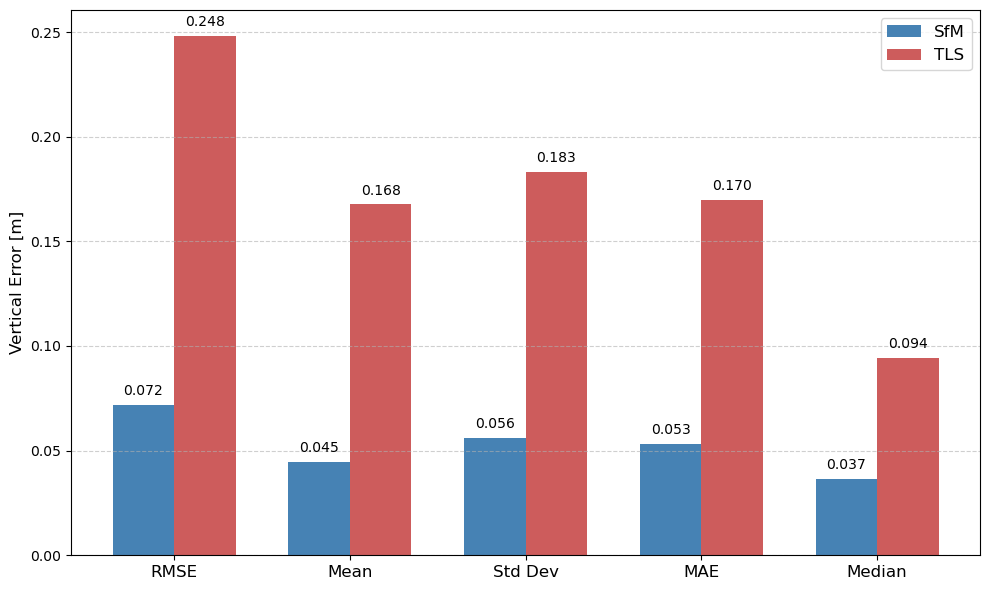

In [7]:
def load_las_z(filepath):
    las = laspy.read(filepath)
    return np.vstack((las.x, las.y, las.z)).T

def load_rtk(filepath):
    rtk_df = pd.read_csv(filepath, header=None)
    rtk_coords = rtk_df.iloc[:, :2].values  # X, Y
    rtk_elevations = rtk_df.iloc[:, 2].values  # Z
    return rtk_coords, rtk_elevations

def vertical_errors(cloud, rtk_coords, rtk_z):
    tree = KDTree(cloud[:, :2])
    _, idx = tree.query(rtk_coords, k=1)
    cloud_z_at_rtk = cloud[idx[:, 0], 2]
    errors = cloud_z_at_rtk - rtk_z
    return errors

def compute_stats(errors):
    return {
        "RMSE": np.sqrt(np.mean(errors**2)),
        "Mean": np.mean(errors),
        "Std Dev": np.std(errors),
        "MAE": np.mean(np.abs(errors)),
        "Median": np.median(errors)
    }

# File paths
sfm_file = "SfM_3_14_2017_MUI.las"
tls_file = "TLS_3_14_2017_MUI.las"
rtk_file = "All_Checks.csv"

# Load data
sfm_cloud = load_las_z(sfm_file)
tls_cloud = load_las_z(tls_file)
rtk_xy, rtk_z = load_rtk(rtk_file)

# Compute vertical errors
sfm_errors = vertical_errors(sfm_cloud, rtk_xy, rtk_z)
tls_errors = vertical_errors(tls_cloud, rtk_xy, rtk_z)

# Compute stats
sfm_stats = compute_stats(sfm_errors)
tls_stats = compute_stats(tls_errors)

# Bar Plot
labels = list(sfm_stats.keys())
sfm_values = [sfm_stats[k] for k in labels]
tls_values = [tls_stats[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, sfm_values, width, label='SfM', color='steelblue')
bars2 = ax.bar(x + width/2, tls_values, width, label='TLS', color='indianred')

ax.set_ylabel('Vertical Error [m]', fontsize=12)
#ax.set_title('Vertical Accuracy Comparison (SfM vs TLS)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("absolute_accuracy.jpeg", dpi=300)
plt.show()

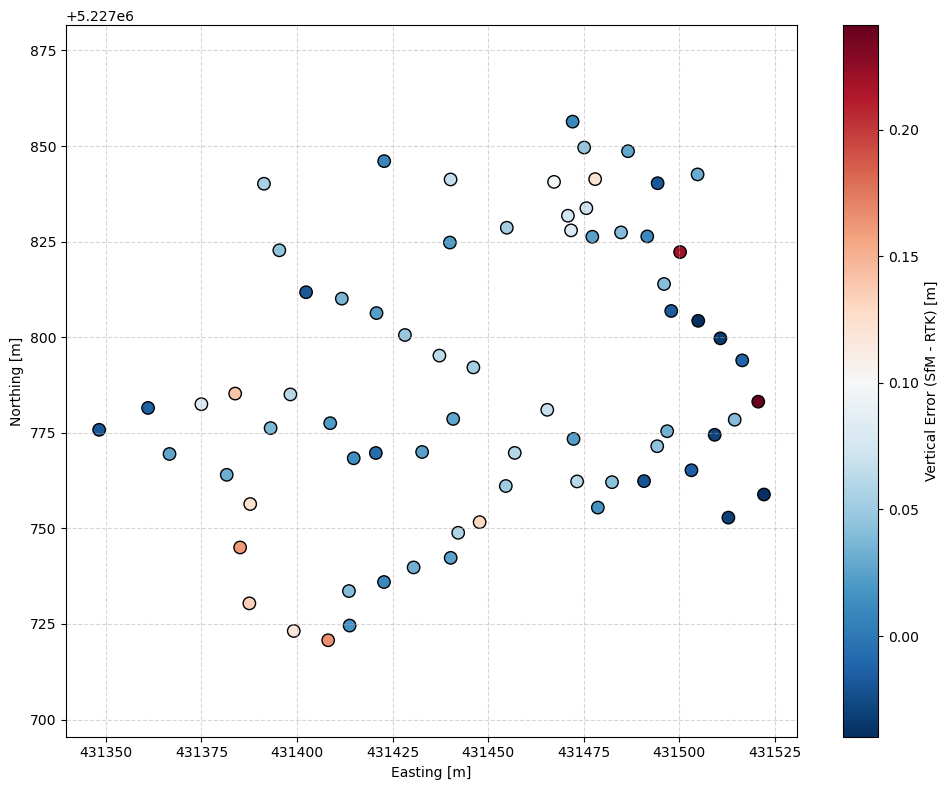

In [10]:
def load_las(filepath):
    las = laspy.read(filepath)
    return np.vstack((las.x, las.y, las.z)).T

def load_rtk(filepath):
    df = pd.read_csv(filepath, header=None)
    return df.iloc[:, 0:2].values, df.iloc[:, 2].values  # X, Y, Z

def compute_errors(cloud, rtk_xy, rtk_z):
    tree = KDTree(cloud[:, :2])
    _, idx = tree.query(rtk_xy, k=1)
    cloud_z = cloud[idx[:, 0], 2]
    errors = cloud_z - rtk_z
    return rtk_xy, errors

# Input files
sfm_file = "SfM_3_14_2017_MUI.las"
rtk_file = "All_Checks.csv"

# Load data
sfm_cloud = load_las(sfm_file)
rtk_xy, rtk_z = load_rtk(rtk_file)

# Compute spatial errors
xy_coords, vertical_errors = compute_errors(sfm_cloud, rtk_xy, rtk_z)

# Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(xy_coords[:, 0], xy_coords[:, 1], c=vertical_errors, cmap='RdBu_r', s=80, edgecolors='k')
plt.colorbar(sc, label='Vertical Error (SfM - RTK) [m]')
#plt.title('Spatial Distribution of Vertical Errors (SfM vs RTK)', fontsize=14)
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.tight_layout()
plt.savefig("spatial_distribution_absolute_error.jpeg", dpi=300)
plt.show()